In [1]:
import numpy as np
from scipy import stats
from CTDGMR.utils import *
from CTDGMR.gmm_reduction import *
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
def gmm_plot2d(means, covs, weights, BBox, log_scale=False, X=None, file_name=None):
    x_ticks = np.linspace(BBox[0], BBox[1], 500)
    y_ticks = np.linspace(BBox[2], BBox[3], 500)
    xx, yy = np.meshgrid(x_ticks, y_ticks)
    zz = np.zeros(xx.shape)
    pos = np.empty(xx.shape + (2, ))
    pos[:, :, 0] = xx
    pos[:, :, 1] = yy
    
    fig, ax = plt.subplots(figsize = (6,6))
  
    for (l, s), w in zip(zip(means, covs), weights):
        zz += ss.multivariate_normal.pdf(pos, mean=l, cov=s) * w
    if log_scale:
        zz = np.log(zz)
    img = ax.imshow(np.flipud(zz), extent = [BBox[0], BBox[1],
                                               BBox[2], BBox[3]])   
    if X is not None:
        ax.scatter(X[:,0], X[:,1], s=1,c='r')
    if file_name is not None:
        fig.savefig(fname=file_name, dpi=200, bbox_inches = 'tight',pad_inches = 0)

# case 1

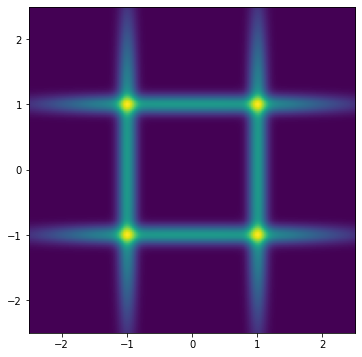

In [3]:
eigvals = [np.array([1, 0.01])]
angles = [0, np.pi/2]

def rotate_matrix(theta):
    return np.array([np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)]).reshape((2,2))

b_covs = []

for i in range(len(angles)):
    rm = rotate_matrix(angles[i])
    for eigval in eigvals:
        b_covs.append(rm@np.diag(eigval)@rm.T)

b_covs = np.stack(b_covs)


b_covs = np.tile(b_covs, (4,1,1))

b_means = np.array([1,1]*2+[-1,1]*2+[-1,-1]*2+[1,-1]*2).reshape((-1,2))

K, d = b_means.shape
b_weights = np.ones((K,))/K

BBox = (-2.5,2.5,-2.5,2.5)                                                              
gmm_plot2d(b_means, b_covs, b_weights, BBox, log_scale=False, X=None)



[0.00983874210105023, 0.6965975797124419, 0.9652729877331774]
[0.0017611439396719164, 0.06255094398220482, 0.08041174450379597]
[1.4142135623730954, 1.5834899527031079, 0.6363961032261165]


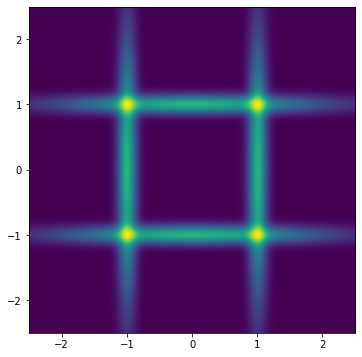

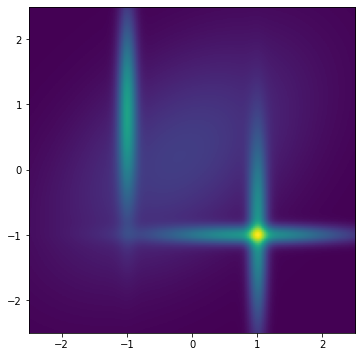

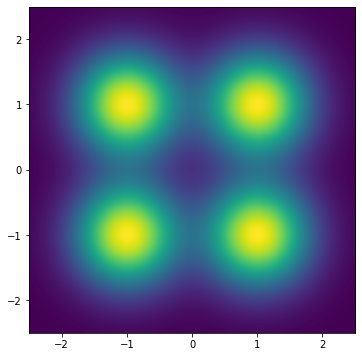

In [4]:
KLs = []
L2s = []
WWs = []

dists = ["KL", "WKL","W2"]
reduced_mix = {}
for dist in dists:
    obj = np.Inf
    final_rmix = None    
    for init in ["Salmond", "Runnalls", "Williams", "W", "kmeans"]:
        rmix = GMR_CTD(b_means, b_covs, b_weights, 4, n_pseudo=1, init_method=init,
                           ground_distance=dist, reg=0.1, max_iter=1000, random_state=0)
        rmix.iterative()
        if rmix.obj < obj:
            final_rmix = rmix
            obj = rmix.obj
    r_means, r_covs, r_weights = final_rmix.reduced_means, final_rmix.reduced_covs, final_rmix.reduced_weights
    means = [b_means, r_means]
    covs = [b_covs, r_covs]
    weights = [b_weights, r_weights]
    L2s.append(GMM_L2(means, covs, weights))
    KLs.append(MC_KL(means, covs, weights))
    WWs.append(GMM_CWD(means, covs, weights, ground_distance="W1"))
    
    reduced_mix[dist] = final_rmix
    gmm_plot2d(final_rmix.reduced_means, final_rmix.reduced_covs, final_rmix.reduced_weights, BBox, log_scale=False, X=None)
    
print(KLs)
print(L2s)
print(WWs)

# for WKL, increase pseduo sample size help with the final result.

# case 2

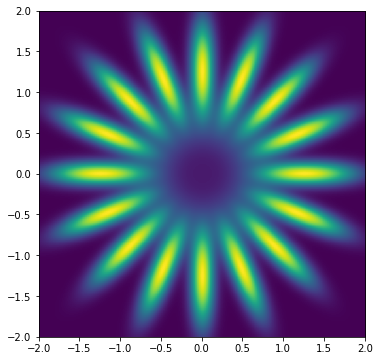

In [5]:
def rotate_mean(r, theta):
    return np.array([r*np.cos(theta), r*np.sin(theta)])

def rotate_matrix(theta):
    return np.array([np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)]).reshape((2,2))

angles = np.linspace(0,2,num=16,endpoint=False) * np.pi
radius = [1, 1.5]

b_means = []
for r in radius:
    for ang in angles:
        b_means.append(rotate_mean(r, ang))

b_means = np.stack(b_means)
        
eigvals = [np.array([0.1,0.01]),np.array([0.1,0.01])]
# eigvals = [np.array([0.01,0.1]), np.array([0.01,0.1])]


b_covs = []
for eigval in eigvals:
    for i in range(angles.shape[0]):
        rm = rotate_matrix(angles[i])
        b_covs.append(rm@np.diag(eigval)@rm.T)


b_covs = np.stack(b_covs)

K, d = b_means.shape
b_weights = np.ones((K,))/K

BBox = (-2,2,-2,2)                                                              
gmm_plot2d(b_means, b_covs, b_weights, BBox, log_scale=False, X=None)



/home/qiong/Nextcloud/Study_Stuff/Research/UBC_PHD/Qiong_Research/code/GMM_reduction/CTDGMR/CTDGMR/utils.py:321: ComplexWarning: Casting complex values to real discards the imaginary part
  "W2")**2
/home/qiong/Nextcloud/Study_Stuff/Research/UBC_PHD/Qiong_Research/code/GMM_reduction/CTDGMR/CTDGMR/utils.py:321: ComplexWarning: Casting complex values to real discards the imaginary part
  "W2")**2


[0.11026553150555883, 0.11026551277877797, 0.08794453453544904]
[0.01665904592476701, 0.016659044476005025, 0.010027712973687514]
[0.3670644185580754, 0.3670643715031959, 0.255817685750581]


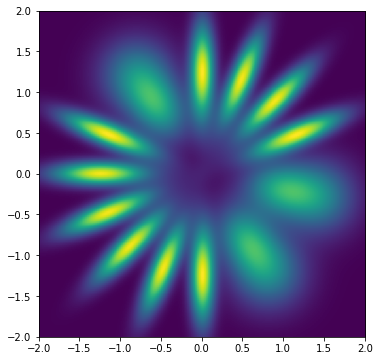

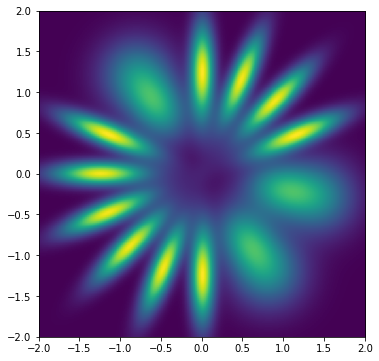

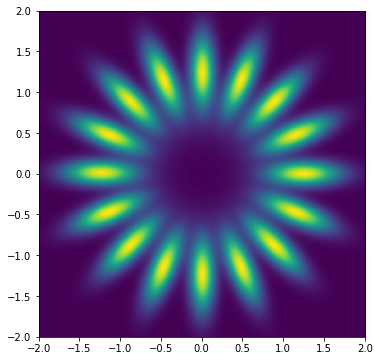

In [6]:
KLs = []
L2s = []
WWs = []

dists = ["KL", "WKL","W2"]
reduced_mix = {}
for dist in dists:
    obj = np.Inf
    final_rmix = None    
    for init in ["Salmond", "Runnalls", "Williams", "W", "kmeans"]:
        rmix = GMR_CTD(b_means, b_covs, b_weights, 16, n_pseudo=10, init_method=init,
                           ground_distance=dist, reg=0.1, max_iter=1000, random_state=0)
        rmix.iterative()
        if rmix.obj < obj:
            final_rmix = rmix
            obj = rmix.obj
    r_means, r_covs, r_weights = final_rmix.reduced_means, final_rmix.reduced_covs, final_rmix.reduced_weights
    means = [b_means, r_means]
    covs = [b_covs, r_covs]
    weights = [b_weights, r_weights]
    L2s.append(GMM_L2(means, covs, weights))
    KLs.append(MC_KL(means, covs, weights))
    WWs.append(GMM_CWD(means, covs, weights, ground_distance="W1"))
    
    reduced_mix[dist] = final_rmix
    gmm_plot2d(final_rmix.reduced_means, final_rmix.reduced_covs, final_rmix.reduced_weights, BBox, log_scale=False, X=None)
    
print(KLs)
print(L2s)
print(WWs)

## case 3 and case 4

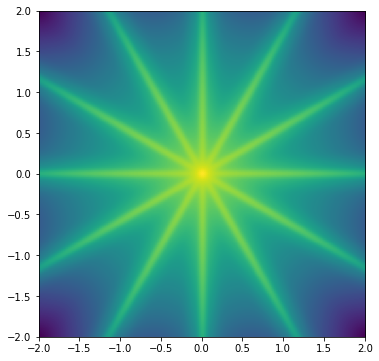

In [7]:
eigvals = [np.array([0.001,1]), np.array([0.01,1]), np.array([0.1, 1])]
angles = np.linspace(0, 1, num=6, endpoint=False) * np.pi

def rotate_matrix(theta):
    return np.array([np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)]).reshape((2,2))

b_covs = []

for i in range(angles.shape[0]):
    rm = rotate_matrix(angles[i])
    for eigval in eigvals:
        b_covs.append(rm@np.diag(eigval)@rm.T)

b_covs = np.stack(b_covs)


K, d = len(eigvals) * angles.shape[0], 2
b_means = np.zeros((K,d))
b_weights = np.array([1/K]*K)
BBox = (-2,2,-2,2)                                                              
gmm_plot2d(b_means, b_covs, b_weights, BBox, log_scale=True, X=None)

### reduce to 6 components

Salmond KL
Runnalls KL
Williams KL
W KL
kmeans KL
Salmond WKL
Runnalls WKL
Williams WKL
W WKL
kmeans WKL
Salmond W2
Runnalls W2
Williams W2


/home/qiong/Nextcloud/Study_Stuff/Research/UBC_PHD/Qiong_Research/code/GMM_reduction/CTDGMR/CTDGMR/utils.py:321: ComplexWarning: Casting complex values to real discards the imaginary part
  "W2")**2


W W2
kmeans W2
[0.09123789708136255, 0.09123789865935586, 0.10630719413205925]
[0.025568816673114364, 0.02556881442169545, 0.036030130195663146]
[0.25354742947716635, 0.2535473802633353, 0.11683172884844355]


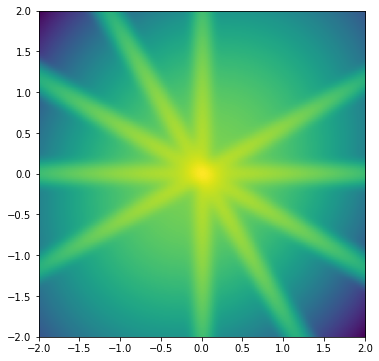

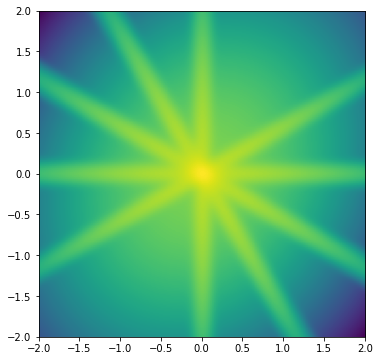

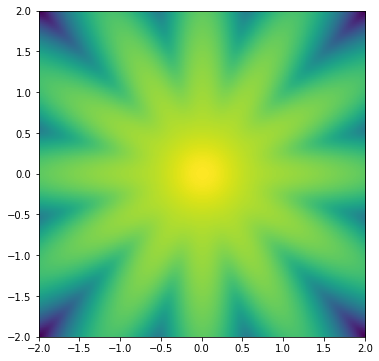

In [8]:
KLs = []
L2s = []
WWs = []

dists = ["KL", "WKL","W2"]
reduced_mix = {}
for dist in dists:
    obj = np.Inf
    final_rmix = None
    for init in ["Salmond", "Runnalls", "Williams", "W", "kmeans"]:
        print(init, dist)
        rmix = GMR_CTD(b_means, b_covs, b_weights, 6, n_pseudo=10, init_method=init,
                           ground_distance=dist, reg=0.1, max_iter=1000, random_state=0)
        rmix.iterative()
        if rmix.obj < obj:
            final_rmix = rmix
            obj = rmix.obj
    r_means, r_covs, r_weights = final_rmix.reduced_means, final_rmix.reduced_covs, final_rmix.reduced_weights
    means = [b_means, r_means]
    covs = [b_covs, r_covs]
    weights = [b_weights, r_weights]
    L2s.append(GMM_L2(means, covs, weights))
    KLs.append(MC_KL(means, covs, weights))
    WWs.append(GMM_CWD(means, covs, weights, ground_distance="W1"))
    
    reduced_mix[dist] = final_rmix
    gmm_plot2d(final_rmix.reduced_means, final_rmix.reduced_covs, final_rmix.reduced_weights, BBox, log_scale=True, X=None)
    
    
print(KLs)
print(L2s)
print(WWs)

### reduce to 12 components

/home/qiong/Nextcloud/Study_Stuff/Research/UBC_PHD/Qiong_Research/code/GMM_reduction/CTDGMR/CTDGMR/utils.py:321: ComplexWarning: Casting complex values to real discards the imaginary part
  "W2")**2
/home/qiong/Nextcloud/Study_Stuff/Research/UBC_PHD/Qiong_Research/code/GMM_reduction/CTDGMR/CTDGMR/utils.py:321: ComplexWarning: Casting complex values to real discards the imaginary part
  "W2")**2
/home/qiong/Nextcloud/Study_Stuff/Research/UBC_PHD/Qiong_Research/code/GMM_reduction/CTDGMR/CTDGMR/gmm_reduction.py:593: ComplexWarning: Casting complex values to real discards the imaginary part
  ground_distance=self.ground_distance)


[0.016258069175988554, 0.317023948045648, 0.1062898980558014]
[0.005407256117131776, 0.10990917510696005, 0.036029760502227115]
[0.09316533794914189, 0.6382952953989292, 0.11583010144431571]


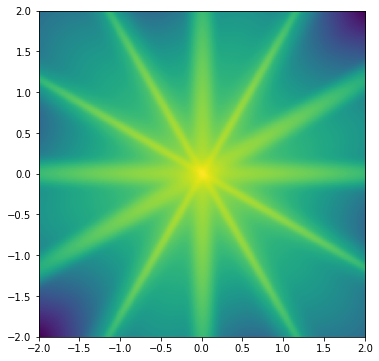

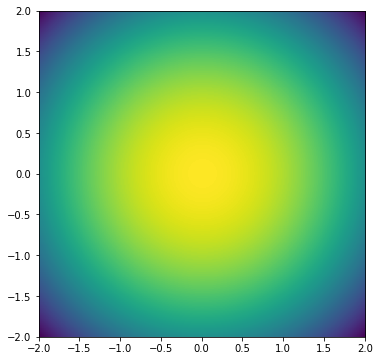

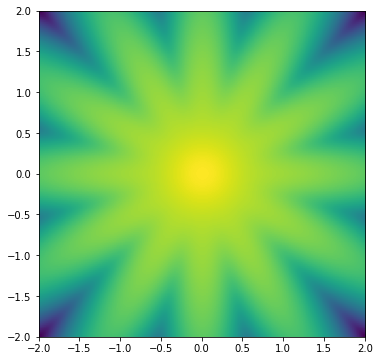

In [9]:
KLs = []
L2s = []
WWs = []

dists = ["KL", "WKL","W2"]
reduced_mix = {}
for dist in dists:
    obj = np.Inf
    final_rmix = None
    for init in ["Salmond", "Runnalls", "Williams", "W", "kmeans"]:
        rmix = GMR_CTD(b_means, b_covs, b_weights, 12, n_pseudo=1, init_method=init,
                           ground_distance=dist, reg=0.1, max_iter=1000, random_state=0)
        rmix.iterative()
        if rmix.obj < obj:
            final_rmix = rmix
            obj = rmix.obj
    r_means, r_covs, r_weights = final_rmix.reduced_means, final_rmix.reduced_covs, final_rmix.reduced_weights
    means = [b_means, r_means]
    covs = [b_covs, r_covs]
    weights = [b_weights, r_weights]
    L2s.append(GMM_L2(means, covs, weights))
    KLs.append(MC_KL(means, covs, weights))
    WWs.append(GMM_CWD(means, covs, weights, ground_distance="W1"))
    
    reduced_mix[dist] = final_rmix
    gmm_plot2d(final_rmix.reduced_means, final_rmix.reduced_covs, final_rmix.reduced_weights, BBox, log_scale=True, X=None)
    
    
print(KLs)
print(L2s)
print(WWs)

/home/qiong/Nextcloud/Study_Stuff/Research/UBC_PHD/Qiong_Research/code/GMM_reduction/CTDGMR/CTDGMR/utils.py:321: ComplexWarning: Casting complex values to real discards the imaginary part
  "W2")**2
/home/qiong/Nextcloud/Study_Stuff/Research/UBC_PHD/Qiong_Research/code/GMM_reduction/CTDGMR/CTDGMR/utils.py:321: ComplexWarning: Casting complex values to real discards the imaginary part
  "W2")**2
/home/qiong/Nextcloud/Study_Stuff/Research/UBC_PHD/Qiong_Research/code/GMM_reduction/CTDGMR/CTDGMR/utils.py:321: ComplexWarning: Casting complex values to real discards the imaginary part
  "W2")**2
/home/qiong/Nextcloud/Study_Stuff/Research/UBC_PHD/Qiong_Research/code/GMM_reduction/CTDGMR/CTDGMR/gmm_reduction.py:593: ComplexWarning: Casting complex values to real discards the imaginary part
  ground_distance=self.ground_distance)


[0.3170239480456481, 0.3170239480456482, 0.429400857158477]
[0.1099091751069601, 0.10990917510696008, 0.08697759941784125]
[0.6382952953989293, 0.6382952953989293, 0.6082776206406996]


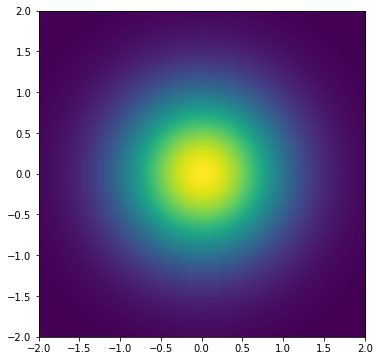

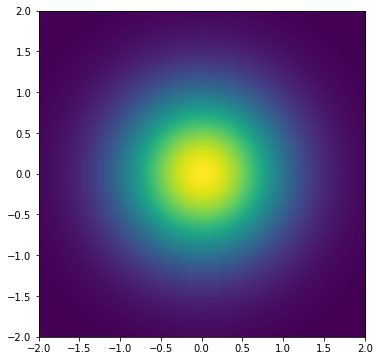

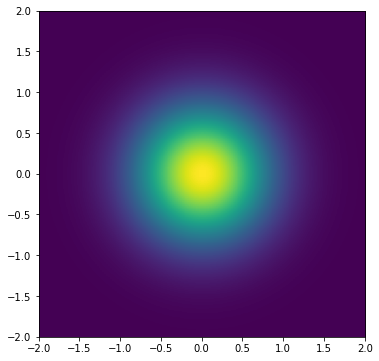

In [10]:
KLs = []
L2s = []
WWs = []

dists = ["KL", "WKL","W2"]
reduced_mix = {}
for dist in dists:
    obj = np.Inf
    final_rmix = None
    for init in ["Salmond", "Runnalls", "Williams", "W", "kmeans"]:
        rmix = GMR_CTD(b_means, b_covs, b_weights, 16, n_pseudo=0, init_method=init,
                           ground_distance=dist, reg=1, max_iter=1000, random_state=0)
        rmix.iterative()
        
        if rmix.obj < obj:
            final_rmix = rmix
            obj = rmix.obj
    r_means, r_covs, r_weights = final_rmix.reduced_means, final_rmix.reduced_covs, final_rmix.reduced_weights
    means = [b_means, r_means]
    covs = [b_covs, r_covs]
    weights = [b_weights, r_weights]
    L2s.append(GMM_L2(means, covs, weights))
    KLs.append(MC_KL(means, covs, weights))
    WWs.append(GMM_CWD(means, covs, weights, ground_distance="W1"))
    
    reduced_mix[dist] = final_rmix
    gmm_plot2d(final_rmix.reduced_means, final_rmix.reduced_covs, final_rmix.reduced_weights, BBox, log_scale=False)
    
print(KLs)
print(L2s)
print(WWs)